In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/amir/PycharmProjects/rqc_internship/sensor_repo


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from os.path import join as jn
import os
import yaml
import torch
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset

In [3]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
with open('pathes.yaml') as conf_file:
    path_config = yaml.safe_load(conf_file)


## Matplotlib version

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

base_model_path = path_config['base_model_path']
base_model = torch.load(base_model_path, map_location=device)

pressure_path = path_config['p_video_path']
signal_path = path_config['s_video_path']


video_names = [x for x in os.listdir(pressure_path) if x.endswith('.npy')]

In [5]:
name = video_names[1]
pressure = np.load(jn(pressure_path, name))
signal = np.load(jn(signal_path, name))

IndexError: list index out of range

In [9]:
with torch.no_grad():
    prediction = base_model(torch.tensor(signal))

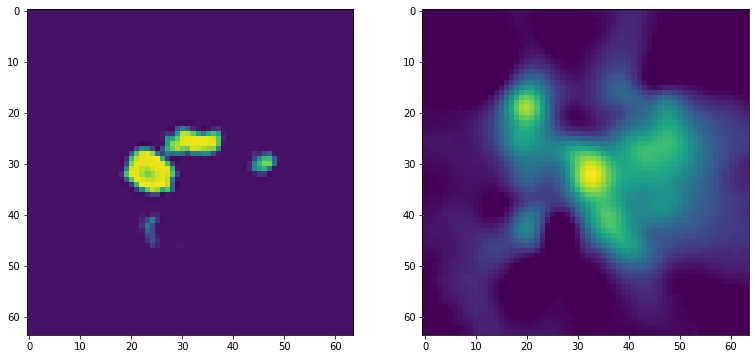

In [11]:
N = 210

plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
plt.imshow(pressure[N])
plt.subplot(1, 2, 2)
plt.imshow(prediction[N])


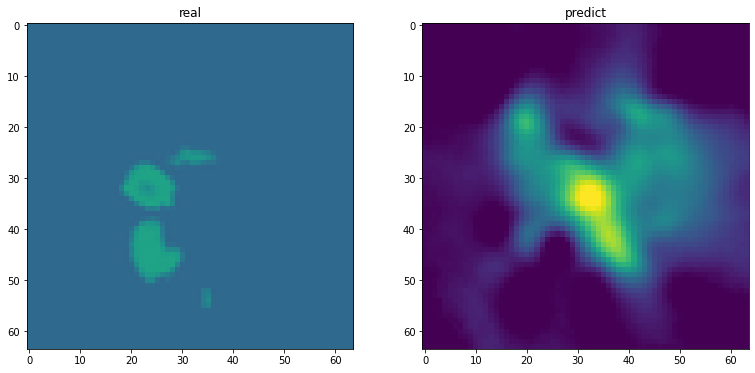

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
# ax = plt.axes(xlim=(0, prediction.shape[-2]), ylim=(0, prediction.shape[-1]))
labels=['real', 'predict']

line0 = axes[0].imshow(pressure[280], vmin=0, vmax=240)
line1 = axes[1].imshow(prediction[280])
axes[0].set_title(labels[0])
axes[1].set_title(labels[1])

def init():
    line0.set_data([[]])
    line1.set_data([[]])
    
def animate(i):
    line0.set_data(pressure[210+i])
    line1.set_data(prediction[i])
    return line0, line1

anim = FuncAnimation(fig, animate, #init_func=init,
                               frames=20, 
                               repeat_delay=500,
                               interval=50) # delay between frames in ms

# animate(3)
anim.save('video_pipeline/test_vis.gif', writer='imagemagick')


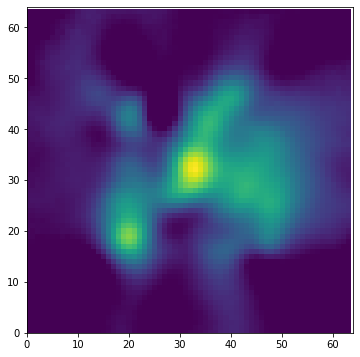

In [34]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(xlim=(0, prediction.shape[-2]), ylim=(0, prediction.shape[-1]))
line = ax.imshow(prediction[280])

line.set_data([[]])
line.set_data(prediction[280])

plt.show()

In [65]:
def animate_two_datasets(real, predict, filename="video_pipeline/predict_vis.gif", labels=['real', 'predict'], size=(13, 6)):
    fig, axes = plt.subplots(1, 2, figsize=size)
    line0 = axes[0].imshow(real[0], vmin=real.min(), vmax=real.max())
    axes[0].set_title(labels[0])
    line1 = axes[1].imshow(predict[0], vmin=predict.min(), vmax=predict.max())
    axes[1].set_title(labels[1])

    def animate(i):
        line0.set_data(real[i])
        line1.set_data(predict[i])
        return line0, line1

    anim = FuncAnimation(fig, animate,
                                frames=min(len(real), len(predict)),
                                repeat_delay=500,
                                interval=50) # delay between frames in ms

    anim.save(filename, writer='imagemagick')



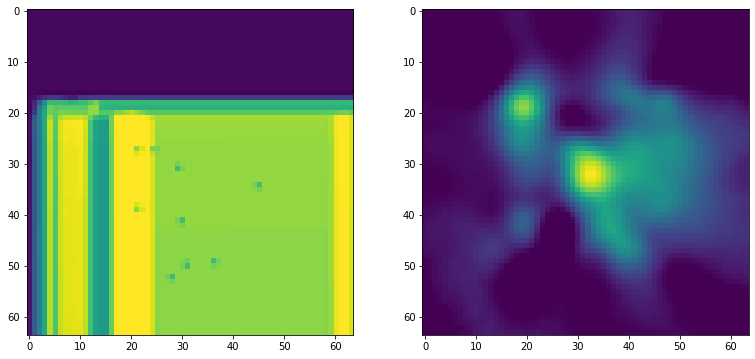

In [66]:
animate_two_datasets(pressure[150:290], prediction[150:290])

# Сохранение склеенных картинок без matplotlib

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

v_model_path = path_config['v_model_path']
v_model = torch.load(v_model_path+'/'+config['video_train']['model_name']+'.pt', 
    map_location=device)

pressure_path = path_config['p_video_path']
signal_path = path_config['s_video_path']


video_names = [x for x in os.listdir(pressure_path) if x.endswith('.npy')]

In [40]:
name = video_names[0]
pressure = np.load(jn(pressure_path, name))
signal = np.load(jn(signal_path, name))

In [29]:
from video_module import *

In [41]:
prediction = 50*predict(v_model, signal, device, initial_pressure=pressure[0])
prediction.shape

(299, 64, 64)

In [42]:
pressure = pressure[-prediction.shape[0]:]
pressure.shape

(299, 64, 64)

### pillow image merging

In [12]:
from PIL import Image
import matplotlib as mpl

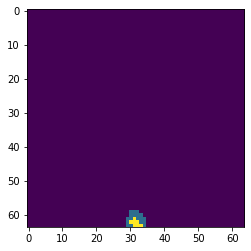

In [10]:
array = pressure[-59]
plt.imshow(array);

In [11]:
image = Image.fromarray((mpl.cm.gist_earth(array)*255).astype(np.uint8))
image.show()

In [20]:
def to_pillow(numpy_array):
    normed = (numpy_array-numpy_array.min())*255/(numpy_array.max()-numpy_array.min())
    return Image.fromarray(normed.astype(np.uint8))

In [21]:
image1, image2 = to_pillow(pressure[-59]), to_pillow(prediction[-59])
image1.show()
image2.show()

In [22]:
merging = Image.new('L', (64*2, 64))
merging.paste(image1, (0, 0))
merging.paste(image2, (64, 0))

In [23]:
merging.show()

### cv2 to video convertion

In [9]:
import cv2

In [14]:
video = cv2.VideoWriter('vis.avi', 0, 1, (2*64,64))


In [15]:
result = []

In [ ]:
for i in range(len(prediction)):
    image1, image2 = to_pillow(pressure[i]), to_pillow(prediction[i])
    merging = Image.new('L', (64*2, 64))
    merging.paste(image1, (0, 0))
    merging.paste(image2, (64, 0))
    result.append(merging)


In [75]:
result[0].show()

In [80]:
result[0].save('out.gif', save_all=True, loop=0, duration=300, append_images=result[1:])

In [81]:
np.array(image1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [16]:
video.write(np.array(image1))

NameError: name 'image1' is not defined

In [83]:
video.release()

In [20]:
visual_chains([pressure, prediction], 'vis6')

TypeError: Cannot handle this data type: (1, 1, 8), |u1

In [36]:
prediction = mpl.cm.gist_earth(prediction, norm=None)
pressure = mpl.cm.gist_earth(pressure, norm=None)

In [16]:
pressure.shape

(299, 64, 64, 4)

In [18]:
chains = np.concatenate([pressure, prediction], -2)
# norming
chains = ((chains - chains.min()) * 255 /
            (chains.max() - chains.min())).astype(np.uint8)
video = cv2.VideoWriter('vis4.avi', 0, 10, chains.shape[-2:], 0)
for i in range(len(chains)):
    print(i)
    video.write(chains[i, ..., np.newaxis])
    cv2.imshow('a', chains[i])
    cv2.waitKey(0) 
video.release()
cv2.destroyAllWindows()     


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Final try with Image and gif

In [ ]:
# prediction = mpl.cm.gist_earth(prediction)
# pressure = mpl.cm.gist_earth(pressure)

In [38]:
def visual_chains(list_of_chains, outpath):
    '''
    Params:
    list_of_chains: List[np.array-s]
    outpath: (str) path for gif video 
    '''
    chains = np.concatenate(list_of_chains, -2)
    # norming
    chains = ((chains - chains.min()) * 255 /
              (chains.max() - chains.min())).astype(np.uint8)
    images = []
    for i in range(len(chains)):
        images.append(Image.fromarray(chains[i]))
    images[0].save(outpath+".gif", save_all=True, loop=0, duration=100, append_images=images[1:])

In [39]:
visual_chains([pressure, prediction], 'vis6')

In [26]:
chains = pressure
chains = ((chains - chains.min()) * 255 /
              (chains.max() - chains.min())).astype(np.uint8)
images = []
for i in range(len(chains)):
    images.append(Image.fromarray(chains[i]))